# Part 1: Getting started

In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)
import os

os.environ['PATH'] = os.environ['XILINX_VITIS'] + '/bin:' + os.environ['PATH']

2025-03-10 17:44:55.419772: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Fetch the jet tagging dataset from Open ML

In [2]:
data = fetch_openml('hls4ml_lhc_jets_hlf')
X, y = data['data'], data['target']

### Let's print some information about the dataset
Print the feature names and the dataset shape

In [3]:
print(data['feature_names'])
print(X.shape, y.shape)
print(X[:5])
print(y[:5])

['zlogz', 'c1_b0_mmdt', 'c1_b1_mmdt', 'c1_b2_mmdt', 'c2_b1_mmdt', 'c2_b2_mmdt', 'd2_b1_mmdt', 'd2_b2_mmdt', 'd2_a1_b1_mmdt', 'd2_a1_b2_mmdt', 'm2_b1_mmdt', 'm2_b2_mmdt', 'n2_b1_mmdt', 'n2_b2_mmdt', 'mass_mmdt', 'multiplicity']
(830000, 16) (830000,)
      zlogz  c1_b0_mmdt  c1_b1_mmdt  c1_b2_mmdt  c2_b1_mmdt  c2_b2_mmdt  \
0 -2.935125    0.383155    0.005126    0.000084    0.009070    0.000179   
1 -1.927335    0.270699    0.001585    0.000011    0.003232    0.000029   
2 -3.112147    0.458171    0.097914    0.028588    0.124278    0.038487   
3 -2.666515    0.437068    0.049122    0.007978    0.047477    0.004802   
4 -2.484843    0.428981    0.041786    0.006110    0.023066    0.001123   

   d2_b1_mmdt  d2_b2_mmdt  d2_a1_b1_mmdt  d2_a1_b2_mmdt  m2_b1_mmdt  \
0    1.769445    2.123898       1.769445       0.308185    0.135687   
1    2.038834    2.563099       2.038834       0.211886    0.063729   
2    1.269254    1.346238       1.269254       0.246488    0.115636   
3    0.966505  

As you saw above, the `y` target is an array of strings, e.g. \['g', 'w',...\] etc.
We need to make this a "One Hot" encoding for the training.
Then, split the dataset into training and validation sets

In [4]:
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y, 5)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(y[:5])

[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]


In [5]:
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)

In [6]:
np.save('X_train_val.npy', X_train_val)
np.save('X_test.npy', X_test)
np.save('y_train_val.npy', y_train_val)
np.save('y_test.npy', y_test)
np.save('classes.npy', le.classes_)

## Now construct a model
We'll use 3 hidden layers with 64, then 32, then 32 neurons. Each layer will use `relu` activation.
Add an output layer with 5 neurons (one for each class), then finish with Softmax activation.

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks

In [8]:
model = Sequential()
model.add(Dense(64, input_shape=(16,), name='fc1', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu1'))
model.add(Dense(32, name='fc2', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu2'))
model.add(Dense(32, name='fc3', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu3'))
model.add(Dense(5, name='output', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='softmax', name='softmax'))

## Train the model
We'll use Adam optimizer with categorical crossentropy loss.
The callbacks will decay the learning rate and save the model into a directory 'model_1'
The model isn't very complex, so this should just take a few minutes even on the CPU.
If you've restarted the notebook kernel after training once, set `train = False` to load the trained model.

In [9]:
train = True
if train:
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=0.000001,
        lr_cooldown=2,
        lr_minimum=0.0000001,
        outputDir='model_1',
    )
    model.fit(
        X_train_val,
        y_train_val,
        batch_size=1024,
        epochs=10,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks.callbacks,
    )
else:
    from tensorflow.keras.models import load_model

    model = load_model('model_1/KERAS_check_best_model.h5')

Epoch 1/10
  1/487 [..............................] - ETA: 4:00 - loss: 1.7834 - accuracy: 0.1807WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0017s vs `on_train_batch_end` time: 0.0024s). Check your callbacks.


466/487 [===========================>..] - ETA: 0s - loss: 0.9580 - accuracy: 0.6870
***callbacks***
saving losses to model_1/losses.log

Epoch 1: val_loss improved from inf to 0.82274, saving model to model_1/KERAS_check_best_model.h5

Epoch 1: val_loss improved from inf to 0.82274, saving model to model_1/KERAS_check_best_model_weights.h5

Epoch 1: saving model to model_1/KERAS_check_model_last.h5

Epoch 1: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 2s 3ms/step - loss: 0.9519 - accuracy: 0.6891 - val_loss: 0.8227 - val_accuracy: 0.7351 - lr: 0.0010
Epoch 2/10
 60/487 [==>...........................] - ETA: 0s - loss: 0.8140 - accuracy: 0.7358

/home/minh/miniconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


475/487 [============================>.] - ETA: 0s - loss: 0.7980 - accuracy: 0.7411
***callbacks***
saving losses to model_1/losses.log

Epoch 2: val_loss improved from 0.82274 to 0.78670, saving model to model_1/KERAS_check_best_model.h5

Epoch 2: val_loss improved from 0.82274 to 0.78670, saving model to model_1/KERAS_check_best_model_weights.h5

Epoch 2: saving model to model_1/KERAS_check_model_last.h5

Epoch 2: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 1s 2ms/step - loss: 0.7977 - accuracy: 0.7412 - val_loss: 0.7867 - val_accuracy: 0.7440 - lr: 0.0010
Epoch 3/10
486/487 [============================>.] - ETA: 0s - loss: 0.7721 - accuracy: 0.7479
***callbacks***
saving losses to model_1/losses.log

Epoch 3: val_loss improved from 0.78670 to 0.76976, saving model to model_1/KERAS_check_best_model.h5

Epoch 3: val_loss improved from 0.78670 to 0.76976, saving model to model_1/KERAS_check_best_model_weig

## Check performance
Check the accuracy and make a ROC curve

5188/5188 [==============================] - 3s 534us/step
Accuracy: 0.7595060240963856


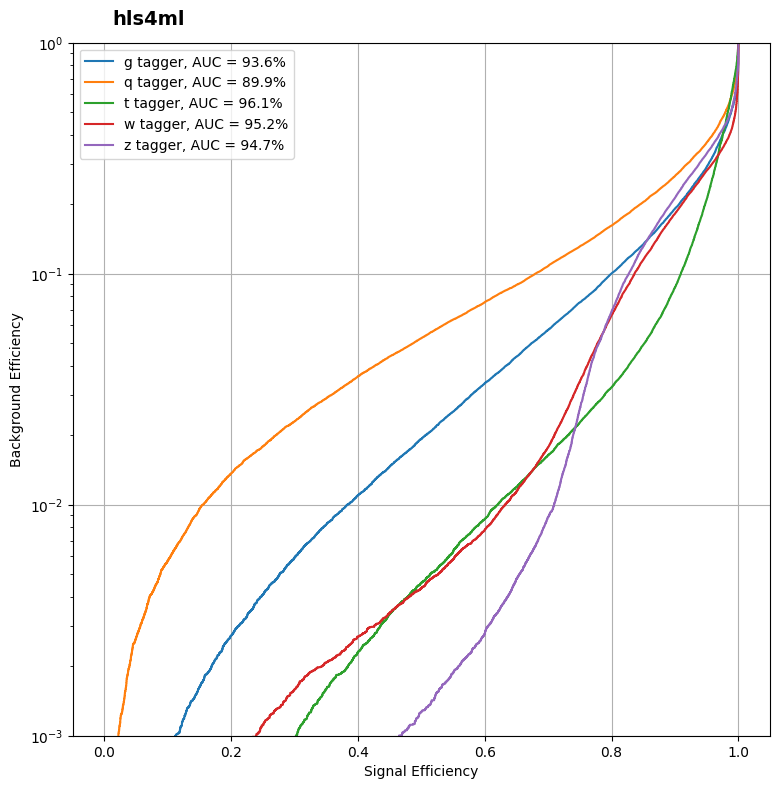

In [10]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

y_keras = model.predict(X_test)
print("Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
plt.figure(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, le.classes_)

## Convert the model to FPGA firmware with hls4ml
Now we will go through the steps to convert the model we trained to a low-latency optimized FPGA firmware with hls4ml.
First, we will evaluate its classification performance to make sure we haven't lost accuracy using the fixed-point data types. 
Then we will synthesize the model with Vitis HLS and check the metrics of latency and FPGA resource usage.

### Make an hls4ml config & model
The hls4ml Neural Network inference library is controlled through a configuration dictionary.
In this example we'll use the most simple variation, later exercises will look at more advanced configuration.

In [16]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(model, granularity='model', backend='Vitis')
print("-----------------------------------")
print("Configuration")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, backend='Vitis', output_dir='model_1/hls4ml_prj', 
    #part='xcu250-figd2104-2L-e'
    part='xc7z020clg400-1' # pynq-z1
)

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [None, 5]
-----------------------------------
Configuration
Model
  Precision
    default:         fixed<16,6>
  ReuseFactor:       1
  S

Let's visualise what we created. The model architecture is shown, annotated with the shape and data types

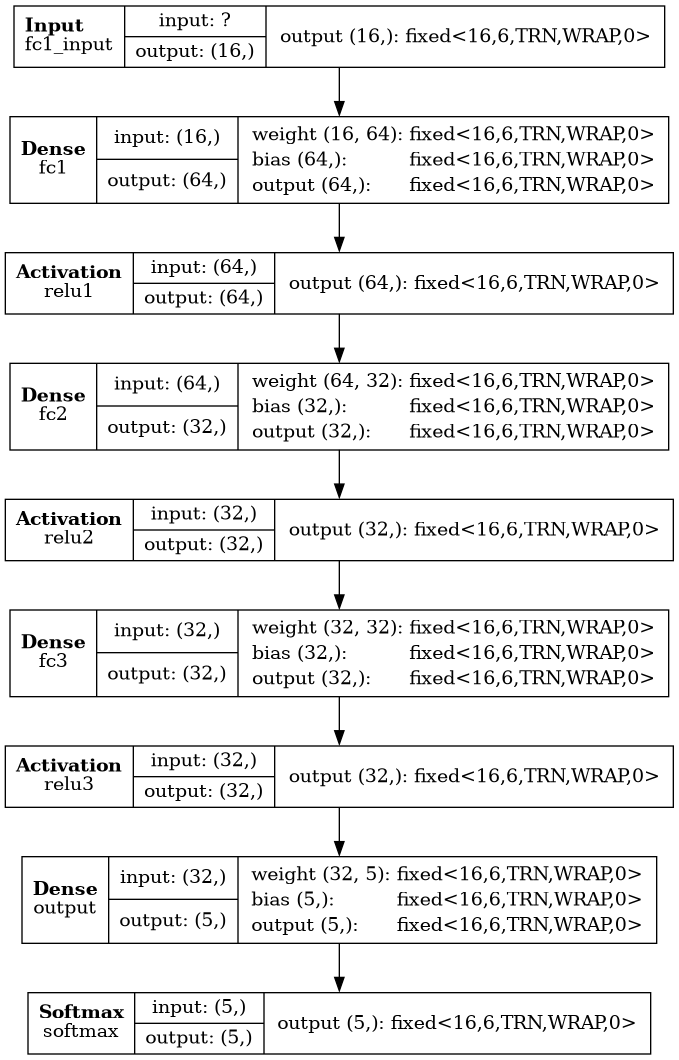

In [17]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

## Compile, predict
Now we need to check that this model performance is still good. We compile the hls_model, and then use `hls_model.predict` to execute the FPGA firmware with bit-accurate emulation on the CPU.

In [18]:
hls_model.compile()
X_test = np.ascontiguousarray(X_test)
y_hls = hls_model.predict(X_test)

Writing HLS project
Done


## Compare
That was easy! Now let's see how the performance compares to Keras:

Keras  Accuracy: 0.7595060240963856
hls4ml Accuracy: 0.759144578313253


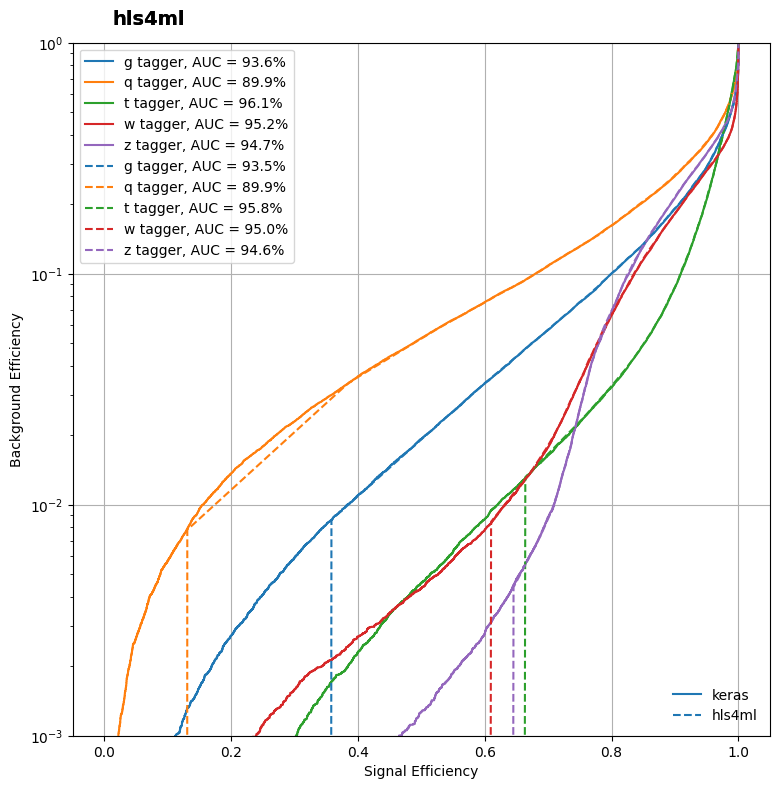

In [14]:
print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, le.classes_)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_hls, le.classes_, linestyle='--')

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['keras', 'hls4ml'], loc='lower right', frameon=False)
ax.add_artist(leg)

## Synthesize
Now we'll actually use Vitis HLS to synthesize the model. We can run the build using a method of our `hls_model` object.
After running this step, we can integrate the generated IP into a workflow to compile for a specific FPGA board.
In this case, we'll just review the reports that Vitis HLS generates, checking the latency and resource usage.

**This can take several minutes.**

While the C-Synthesis is running, we can monitor the progress looking at the log file by opening a terminal from the notebook home, and executing:

`tail -f model_1/hls4ml_prj/vitis_hls.log`

In [20]:
hls_model.build(csim=False)


****** Vitis HLS - High-Level Synthesis from C, C++ and OpenCL v2024.2 (64-bit)
  **** SW Build 5238294 on Nov  8 2024
  **** IP Build 5239520 on Sun Nov 10 16:12:51 MST 2024
  **** SharedData Build 5239561 on Fri Nov 08 14:39:27 MST 2024
  **** Start of session at: Mon Mar 10 17:49:13 2025
    ** Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.
    ** Copyright 2022-2024 Advanced Micro Devices, Inc. All Rights Reserved.

source /tools/Xilinx/Vitis/2024.2/scripts/vitis_hls/hls.tcl -notrace
INFO: [HLS 200-10] For user 'minh' on host 'minhLenovo' (Linux_x86_64 version 6.8.0-52-generic) on Mon Mar 10 17:49:14 EET 2025
INFO: [HLS 200-10] On os Ubuntu 22.04.5 LTS
INFO: [HLS 200-10] In directory '/home/minh/Documents/UTU-Doctorate/control_theory/hls4ml-tutorial/model_1/hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-1510] Running: open_project myproject_prj 
INFO: [HLS 200-10] Opening project '/home/minh/Documents/UTU-Doctorate/control_theory/hls4ml-tutorial/model_1/hls4

INFO: [HLS 214-131] Inlining function 'nnet::product::mult<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0> >::product(ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>)' into 'void nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>(ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>*, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>*, config2::weight_t*, config2::bias_t*)' (firmware/nnet_utils/nnet_dense_latency.h:42:27)
INFO: [HLS 214-131] Inlining function 'nnet::DenseLatency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>::dense(ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>*, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>*, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>*, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>*)' into 'void nnet::dense<ap_fixed<16, 6, (ap_q_mode

INFO: [HLS 200-111] Finished Standard Transforms: CPU user time: 0.28 seconds. CPU system time: 0.02 seconds. Elapsed time: 0.32 seconds; current allocated memory: 352.285 MB.
INFO: [HLS 200-10] Checking synthesizability ...
INFO: [HLS 200-111] Finished Checking Synthesizability: CPU user time: 0.36 seconds. CPU system time: 0 seconds. Elapsed time: 0.37 seconds; current allocated memory: 360.539 MB.
INFO: [XFORM 203-602] Inlining function 'nnet::reduce<ap_fixed<18, 8, (ap_q_mode)0, (ap_o_mode)0, 0>, 5, nnet::Op_add<ap_fixed<18, 8, (ap_q_mode)0, (ap_o_mode)0, 0> > >' into 'nnet::softmax_stable<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, softmax_config13>' (firmware/nnet_utils/nnet_activation.h:262) automatically.
INFO: [XFORM 203-401] Performing if-conversion on hyperblock to (firmware/nnet_utils/nnet_activation.h:270:1) in function 'nnet::softmax_stable<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap

INFO: [SCHED 204-61] Pipelining function 'dense_latency<ap_fixed<16, 6, 5, 3, 0>, ap_fixed<16, 6, 5, 3, 0>, config8>'.
INFO: [HLS 200-1470] Pipelining result : Target II = NA, Final II = 1, Depth = 7, function 'dense_latency<ap_fixed<16, 6, 5, 3, 0>, ap_fixed<16, 6, 5, 3, 0>, config8>'
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111] Finished Scheduling: CPU user time: 1.52 seconds. CPU system time: 0.01 seconds. Elapsed time: 1.53 seconds; current allocated memory: 1009.500 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Starting global binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111] Finished Binding: CPU user time: 3.33 seconds. CPU system time: 0.03 seconds. Elapsed time: 3.37 seconds; current allocated memory: 1.031 GB.
INFO: [HLS 200-10] ------

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_latency_ap_fixed_16_6_5_3_0_ap_fixed_16_6_5_3_0_config5_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-104] Estimated max fanout for 'dense_latency_ap_fixed_16_6_5_3_0_ap_fixed_16_6_5_3_0_config5_s' is 52925 from HDL expression: ((1'b1 == ap_ce_reg) & (1'b0 == ap_block_pp0_stage0_11001))
INFO: [RTGEN 206-100] Generating core module 'mul_16s_10ns_26_2_0': 67 instance(s).
INFO: [RTGEN 206-100] Generating core module 'mul_16s_10s_26_2_0': 59 instance(s).
INFO: [RTGEN 206-100] Generating core module 'mul_16s_11ns_26_2_0': 7 instance(s).
INFO: [RTGEN 206-100] Generating core module 'mul_16s_11s_26_2_0': 7 instance(s).
INFO: [RTGEN 206-100] Generating core module 'mul_16s_5ns_21_2_0': 5 instance(s).
INFO: [RTGEN 206-100] Generating core module 'mul_16s_5s_21_2_0': 14 instance(s).
INFO: [RTGEN 206-1

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'myproject' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/fc1_input' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer13_out_0' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer13_out_1' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer13_out_2' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer13_out_3' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer13_out_4' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on function 'myproject' to 'ap_ctrl_hs'.
INFO: [HLS 200-1030] Apply Unified Pipeline Control on module 'myproject' pipeline 'myproject' pipeline type 'function pipeline'
INFO: [R

{'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '3.648',
  'BestLatency': '50',
  'WorstLatency': '50',
  'IntervalMin': '1',
  'IntervalMax': '1',
  'BRAM_18K': '4',
  'DSP': '2228',
  'FF': '274487',
  'LUT': '131183',
  'URAM': '0',
  'AvailableBRAM_18K': '280',
  'AvailableDSP': '220',
  'AvailableFF': '106400',
  'AvailableLUT': '53200',
  'AvailableURAM': '0'}}

## Check the reports
Print out the reports generated by Vitis HLS. Pay attention to the Latency and the 'Utilization Estimates' sections

In [21]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj/')

Found 1 solution(s) in model_1/hls4ml_prj//myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vitis HLS Report for 'myproject'
* Date:           Mon Mar 10 17:51:09 2025

* Version:        2024.2 (Build 5238294 on Nov  8 2024)
* Project:        myproject_prj
* Solution:       solution1 (Vivado IP Flow Target)
* Product family: zynq
* Target device:  xc7z020-clg400-1


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  |  5.00 ns|  3.648 ns|     1.35 ns|
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+----------+----------+-----+-----+---------+
    |  Latency (cycles) |  Latency (absolute) |  Interval | Pipeline|
    |   min   |   max   |    min   |    max   | min | max |   Type  |
    +---------+---------+----------+------

## Exercise
Since `ReuseFactor = 1` we expect each multiplication used in the inference of our neural network to use 1 DSP. Is this what we see? (Note that the Softmax layer should use 5 DSPs, or 1 per class)
Calculate how many multiplications are performed for the inference of this network...
(We'll discuss the outcome)